<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/Entrenamiento_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inicializadores, normalización por lotes, optimizadores y regularizadores en DL**

In [1]:
# Python ≥3.5 is required
import sys

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Vanishing/Exploding Gradients Problem

# Desvanecimiento/no convergencia del gradiente

- En el backpropagation el gradiente de las capas iniciales no cambia (vanishing)

- En el backpropagation el gradiente se dispara

- En DL se generan gradientes inestables, diferentes capas aprenden a velocidades muy distintas!

- Posibles causas: incializacion tipo $\mathcal{N}(0,1)$ y activación logística, generan que las varianzas de las salidas de las capas sean más grandes que las varianzas de las entradas de las mismas. La sigmoide tiene problemas por saturación además del nivel dc 0.5

- Xavier Glorot y Yoshua Bengio demostraron dichas evidencias en 2010 [Paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?source=post_page---------------------------)

In [2]:
def logit(z): #funcion sigmoid
    return 1 / (1 + np.exp(-z))

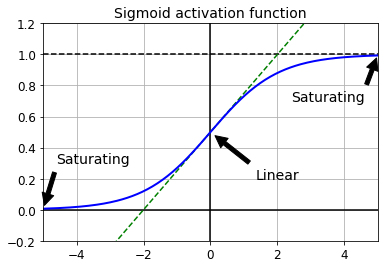

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Inicializadores Xavier (Glorot) y He 

*   Se busca que la información fluya de forma estable en ambas direcciones: forward y backward
*   No la información no deberia ni morir (vanishing) ni explotar o saturarse.

* Clave: la varianza de las salidas de las capas se iguala a la varianza de las entradas de las capas. Además, se espera que el gradiente fluya con igual varianza antes y después de fluir por una capa.

* Dado que no es posible mantenar las claves anteriores por la variabilidad en el número de neuronas y entradas en una capa (fan-in fan-out de la capa), Glorot y Bengio proponen un modelo que mantiene un buen compromiso (inicialmente definido para activaciones sigmoid):

$$ w_0 \sim \mathcal{N}\left(0,1/fan_{avg}\right)$$ 
o
$$ w_0 \sim \mathcal{U}\left(-\sqrt{3/fan_{avg}},+\sqrt{3/fan_{avg}}\right)$$ 

donde $fan_{avg}= (fan_{in}+fan_{out})/2$

* Cuando $fan_{avg}=fan_{in}$ se obtiene el inicializador de Yann LeCun, o LeCun initialization (1990).

* Glorot puede mejorar el rendimiento y la velocidad de entrenamiento considerablemente!

Algunas otras alternativas de inicializadores se basan en las ideas de LeCun y Glorot modificando el uso de $fan_{avg}$ y $fan_{in}$ y el tipo de activación:


|Inicializador|Función de activación| $\sigma^2$ (Normal)|
|---|---|---|
|Glorot| linear, tanh, logist,softmax| 1/$fan_{avg}$|
|He| ReLU y variantes| 2/$fan_{in}$|
|LeCun| SELU| 1/$fan_{in}$|




In [4]:
#keras initializers
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# se escala la variance o rango sobre el que se quiere muestrear
#https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

# Funciones de activación sin saturación
## Nonsaturating Activation Functions

* Aunque la activación en neuronas biológicas se asemejan a la función sigmoide, la saturación es un problema en el entrenamiento de la red (vanishing/exploding)

* Alternativa: ReLU -> simple de implementar y no saturada

* Problema de ReLU: dying ReLU, algunas neuronas marcan cero a la salida por el modelo de la $ReLU(x) = \max(0,x)$.

* El problema del dying ReLU es muy evidente para learning rates grandes, dado que el gradiente es cero para salidas negativas sobre la ReLU, las neuronas seguiran generando ceros!.

 

### Leaky ReLU

$Leaky ReLU(x) = \max(\alpha x,x)$

Algunas variantes de ReLU, buscando jugar con el factor de escala $\alpha$ para inducir un "coma" en las neuronas, del cual puedan volver en algún punto del entrenamiento se pueden encontrar en el siguiente [Paper](https://arxiv.org/abs/1505.00853) 2015

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

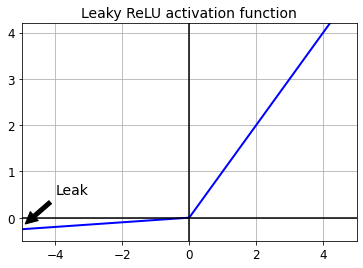

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Pruebas sobre Fashion MNIST en Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5339 - accuracy: 0.8224 - val_loss: 0.5156 - val_accuracy:

Ahora con PReLU (parámetro $\alpha$ se aprende en el entrenamiento):

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6965 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7884
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5917 - accuracy: 0.8058 - val_loss: 0.5656 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

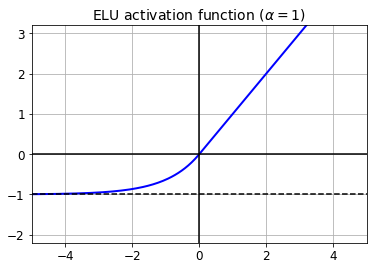

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()


$
ELU_\alpha(x) = \left\{\begin{split} \alpha(\exp(x)-1)& \quad if \quad & x < 0 \\
x & \quad if \quad & x \geq 0 \\
\end{split}\right. 
$


In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

* Esta función de activación se propusó en 2017 [Paper](https://arxiv.org/pdf/1706.02515.pdf) por Günter Klambauer, Thomas Unterthiner y Andreas Mayr. 

* Garantiza una auto-normalización para modelos secuenciales.


$
SELU_\alpha(x) = \lambda\left\{\begin{split} \alpha(\exp(x)-1)& \quad if \quad & x < 0 \\
x & \quad if \quad & x \geq 0 \\
\end{split}\right. 
$


In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

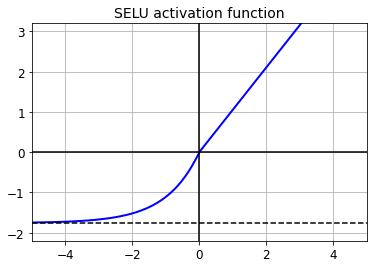

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

* En general, los hiperparámetros de SELU ($\lambda$ y $\alpha$) se ajustan de tal forma que la salida promedio de cada neurona este cercana a 0, y la desviación estandard cercana a 1 (asumiendo que las entradas se estandarizan de igual  manera). 

* Para modelos profundos y densos se evita los problemas de vanishing/expoding

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Utilizando SELU en  modelos densos:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Probando en Fashion MNIST:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Antes de entrenar recuerde normalizar las entradas a media 0 y std 1:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 11ms/step - loss: 1.3528 - accuracy: 0.4809 - val_loss: 1.2061 - val_accuracy: 0.5448
Epoch 2/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.9559 - accuracy: 0.6278 - val_loss: 0.7618 - val_accuracy: 0.7126
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7271 - accuracy: 0.7231 - val_loss: 0.6875 - val_accuracy: 0.7380
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.6208 - accuracy: 0.7722 - val_loss: 0.5628 - val_accuracy: 0.7954
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5611 - accuracy: 0.8014 - val_loss: 0.5175 - val_accuracy: 0.8220


Si se prueba ReLU en vez de SELU:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 11ms/step - loss: 1.7818 - accuracy: 0.2725 - val_loss: 1.2527 - val_accuracy: 0.4458
Epoch 2/5
1719/1719 [==============================] - 18s 11ms/step - loss: 1.1336 - accuracy: 0.5337 - val_loss: 0.9433 - val_accuracy: 0.6416
Epoch 3/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.8754 - accuracy: 0.6527 - val_loss: 0.7847 - val_accuracy: 0.6892
Epoch 4/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.8052 - accuracy: 0.6863 - val_loss: 1.3040 - val_accuracy: 0.5224
Epoch 5/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.6990 - accuracy: 0.7388 - val_loss: 0.6137 - val_accuracy: 0.7760


No tan buen resultado, problemas de vanishing/exploding.

## Sugerencias:

* En general, el ranking de rendimiento es el seguiente: SELU>ELU>leakyReLU>ReLU>tanh>sigmoid.

* Si la red esta auto-normalizadas ELU puede rendir más que SELU (SELU no es suave en $x=0$).

* Si se requiere buena velocidad de cómputo se sugiere LeakyReLU.

* ReLU es la más utilizada por su buen compromiso, muchos aceleradore de cómputo están optimizados para trabajar con esta activación.

# Normalización por lote
## Batch Normalization - BN

* Aunque un buen inicializador y una buena función de activación previenen los problemas de vanishing/exploding, al inicio del entrenamiento, durante las iteraciones el vanishing/exploding puede volver!.

* En el 2015 [Paper](https://arxiv.org/abs/1502.03167), se propone la técnica Batch Normalization, que consiste en añadir una operación antes y después de cada capa.

* La normalización consiste de dos operaciones: escalamiento y traslación (dos nuevos parámetros por aprender en cada capa).

* Si la capa BN se añade como primera capa, entonces no es necesario escalar los datos de entrada.

* BN evalua la media y std de la entrada a la capa sobre el mini-batch (mini-lote) actual, con base en:


$\mathbf{\mu}_B = \frac{1}{N_B}\sum_{i=1}^{N_B} \mathbf{x}^{(i)}$

$\mathbf{\sigma}_B^2 = \frac{1}{N_B}\sum_{i=1}^{N_B} (\mathbf{x}^{(i)}-\mathbf{\mu}_B)^2$

$\hat{\mathbf{x}}^{(i)}= \frac{\mathbf{x}^{(i)}-\mathbf{\mu}_B}{\sqrt{\mathbf{\sigma}_B^2+\epsilon}}$

$\mathbf{z}^{(i)}=\mathbf{\gamma}\otimes \hat{\mathbf{x}}^{(i)}+\mathbf{\beta}$

* BN estandariza y luego reescala.

* Para datos nuevos se utliza promediado movil durante el entrenamiento.

* En resumen se estiman cuatro parámetros: $\gamma$ (escala), $\beta$ (traslación) se aprenden por backpropagation, y $\mu$ (media  final de entrada) y $\sigma$ (desviación final de entrada) por promediado móvil.

* NOTA: $\mu$ y $\sigma$ se estiman en entrenamiento pero solo se usen después de entrenar para evaluar datos nuevos.

* BN ha mostrado grandes resultados en procesado de imágenes, por ejemplo en ImageNet.

* El problema de vanishing se reduce e incluse se pueden utlizar activaciones saturadas como tanh  y sigmoid con BN.

* Además, BN es menos sensible a la inicialización de los pesos y  permite usar learning rates más grandes.

* BN se puede entender también como un regularizador al escalar y trasladar el flujo de información en la red.

* Problema: BN incluye más costo y operaciones en el entrenamiento y evaluación de la red.





In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables] #parámetros entrenables y no entrenables en BN

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates #operaciones definidas en keras para promediado movil

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[]

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4724 - val_accuracy: 0.8476
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5189 - accuracy: 0.8206 - val_loss: 0.4375 - val_accuracy: 0.8552
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4827 - accuracy: 0.8323 - val_loss: 0.4153 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4565 - accuracy: 0.8406 - val_loss: 0.3998 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4398 - accuracy: 0.8471 - val_loss: 0.3868 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4242 - accuracy: 0.8511 - val_loss: 0.3763 - val_accuracy:

* En algunos casos se sugiere incluir BN antes de las funciones de activación (no hay evidencia completa al respecto).

* La capa antes de BN no necesita el bias dado que el BN lo incluye

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8446
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5109 - accuracy: 0.8280 - val_loss: 0.4433 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4898 - accuracy: 0.8338 - val_loss: 0.4263 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4712 - accuracy: 0.8395 - val_loss: 0.4130 - val_accuracy:

# Recorte del gradiente
## Gradient Clipping

* Para evitar el problema de exploding se recorta (clip) el gradiente para que no supere un umbral dado.

* Método muy utilizado en modelos recurrentes.

* BN dificil de acoplar en RNN (escaldo y traslación de series temporales)

* Para evitar problemas de dirección, se sugiere trabajar con recorte por umbral sobre la norma del gradiente y no sobre los valores puntuales del mismo.

Los optimizadores de keras incluyen `clipnorm` y `clipvalue`:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Reutilizar redes pre-entrenadas para evitar sobreajuste y problemas de convergencia (transfer  learning)


In [46]:
def split_dataset(X, y): # particionar Fashion MNIST 
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]


array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
print(np.unique(y_train_A),np.unique(y_train_B))

[0 1 2 3 4 5 6 7] [0. 1.]


In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [54]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [55]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.5927 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3013 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2974 - accuracy: 0.8974 - val_loss: 0.2896 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.2835 - accuracy: 0.9019 - val_loss: 0.2774 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2730 - accuracy: 0.9060 - val_loss: 0.2734 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2642 - accuracy: 0.9092 - val_loss: 0.2721 - val_accuracy:

In [56]:
model_A.save("my_model_A.h5")

In [57]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [59]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 31ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [61]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [62]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [63]:
for layer in model_B_on_A.layers[:-1]: #definir capas no entrenables
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [64]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 29ms/step - loss: 0.5785 - accuracy: 0.6500 - val_loss: 0.5829 - val_accuracy: 0.6349
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.5420 - accuracy: 0.6800 - val_loss: 0.5455 - val_accuracy: 0.6805
Epoch 3/4
7/7 [==============================] - 0s 13ms/step - loss: 0.5052 - accuracy: 0.7250 - val_loss: 0.5134 - val_accuracy: 0.7120
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.4737 - accuracy: 0.7450 - val_loss: 0.4848 - val_accuracy: 0.7353
Epoch 1/16
7/7 [==============================] - 0s 28ms/step - loss: 0.3954 - accuracy: 0.8150 - val_loss: 0.3456 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 12ms/step - loss: 0.2794 - accuracy: 0.9350 - val_loss: 0.2601 - val_accuracy: 0.9290
Epoch 3/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2081 - accuracy: 0.9650 - val_loss: 0.2109 - val_accuracy: 0.9554
Epoch 4/16
7/7 [===============

Evaluaciones:

In [65]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [66]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06819140166044235, 0.9929999709129333]

Se obtiene  una mejora!

In [67]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

# Optimizadores

* Gradiente  descendiente:

$$\theta \leftarrow \theta -\eta \nabla_\theta J(\theta)$$

* Momentum: considera gradientes previos

$$m  \leftarrow \beta m - \nabla_\theta J(\theta)$$

$$\theta \leftarrow \theta + m $$

$\beta$: hiperparámetro momentum


* Los algoritmos basados en momentum añaden mayor velocidad de 
convergencia.

* En keras el optimizador SGD permite incluir el hiperparámetro de momentum.

* Además, algunas variantes alrededor de los filosofía de mementum incluyen Nestrov, AdaGrad, RMSProp, Adam, Nadam, AdaDelta

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9) #como incluir momentum en SGD

## Nesterov Accelerated Gradient

In [69]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True) #nestrov cálcula el gradiente teniendo en cuenta la dirección del momentum

## AdaGrad

In [70]:
optimizer = keras.optimizers.Adagrad(lr=0.001) # incluye correción de dirección

## RMSProp

In [71]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9) # Mejora adaGrad para estabilizar la convergencia

## Adam Optimization

In [72]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999) # cálcula el momentum de forma adaptativa

## Adamax Optimization

In [73]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999) #cambia la norma l2 en adam con norma infinito

## Nadam Optimization

In [74]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999) # adam + Nestrov -> cálcula gradiente de función con desplazamiento por momentum

# Comparación de los optimizadores:

In [75]:
from IPython.display import Image
Image(url="https://gitcdn.xyz/cdn/Tony607/blog_statics/e1a0b1e060e783bd1978a141acff897ae71bd021/images/optimizer/optimizer.gif")

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```

* Keras usa `c=1` y `s = 1 / decay`

In [76]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [78]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4029 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3781 - accuracy: 0.8659 - val_loss: 0.3717 - val_accuracy: 0.8728
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3458 - accuracy: 0.8770 - val_loss: 0.3747 - val_accuracy: 0.8746
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3251 - accuracy: 0.8827 - val_loss: 0.3501 - val_accuracy: 0.8802
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3102 - accuracy: 0.8893 - val_loss: 0.3448 - val_accuracy: 0.8786
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2966 - accuracy: 0.8934 - val_loss: 0.3414 - val_accuracy: 0.8832
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2868 - accuracy: 0.8974 - val_loss: 0.3355 - val_accuracy:

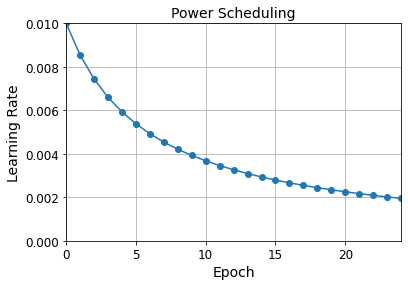

In [79]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [80]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [81]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [83]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8680 - accuracy: 0.7514 - val_loss: 1.2005 - val_accuracy: 0.7024
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7432 - accuracy: 0.7770 - val_loss: 0.5946 - val_accuracy: 0.8354
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6198 - accuracy: 0.8083 - val_loss: 1.7773 - val_accuracy: 0.6222
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5614 - accuracy: 0.8248 - val_loss: 0.5190 - val_accuracy: 0.8336
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4940 - accuracy: 0.8425 - val_loss: 0.5360 - val_accuracy: 0.8584
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4603 - accuracy: 0.8546 - val_loss: 0.5344 - val_accuracy: 0.8380
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4355 - accuracy: 0.8621 - val_loss: 0.5241 - val_accuracy:

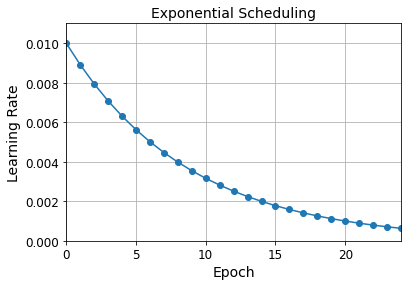

In [84]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [85]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [86]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8047 - accuracy: 0.7648 - val_loss: 0.7934 - val_accuracy: 0.7638
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6547 - accuracy: 0.7982 - val_loss: 0.5054 - val_accuracy: 0.8426
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5437 - accuracy: 0.8283 - val_loss: 0.6026 - val_accuracy: 0.8074
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5315 - accuracy: 0.8347 - val_loss: 0.4816 - val_accuracy: 0.8538
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4878 - accuracy: 0.8504 - val_loss: 0.4530 - val_accuracy: 0.8616
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4186 - accuracy: 0.8650 - val_loss: 0.5545 - val_accuracy: 0.8558
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4012 - accuracy: 0.8721 - val_loss: 0.4371 - val_accuracy:

In [87]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

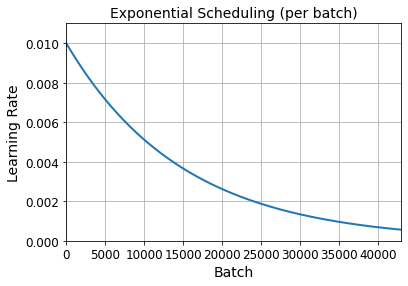

In [88]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [89]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [90]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [91]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8695 - accuracy: 0.7559 - val_loss: 1.0141 - val_accuracy: 0.7006
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8120 - accuracy: 0.7647 - val_loss: 0.6786 - val_accuracy: 0.7860
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8244 - accuracy: 0.7588 - val_loss: 1.1512 - val_accuracy: 0.6078
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9944 - accuracy: 0.6976 - val_loss: 0.9520 - val_accuracy: 0.6888
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8230 - accuracy: 0.7593 - val_loss: 0.8562 - val_accuracy: 0.8110
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4992 - accuracy: 0.8488 - val_loss: 0.4879 - val_accuracy: 0.8600
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4725 - accuracy: 0.8570 - val_loss: 0.5353 - val_accuracy:

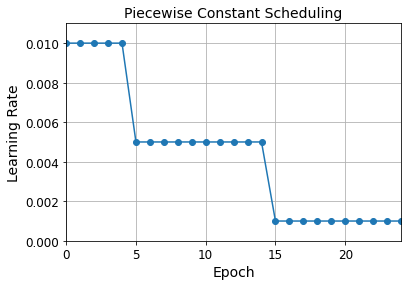

In [92]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

In [94]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5887 - accuracy: 0.8076 - val_loss: 0.4943 - val_accuracy: 0.8420
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5005 - accuracy: 0.8401 - val_loss: 0.5357 - val_accuracy: 0.8434
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5120 - accuracy: 0.8411 - val_loss: 0.4684 - val_accuracy: 0.8610
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5205 - accuracy: 0.8469 - val_loss: 0.4873 - val_accuracy: 0.8538
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5261 - accuracy: 0.8472 - val_loss: 0.5343 - val_accuracy: 0.8536
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5156 - accuracy: 0.8514 - val_loss: 0.6081 - val_accuracy: 0.8450
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5278 - accuracy: 0.8527 - val_loss: 0.6395 - val_accuracy:

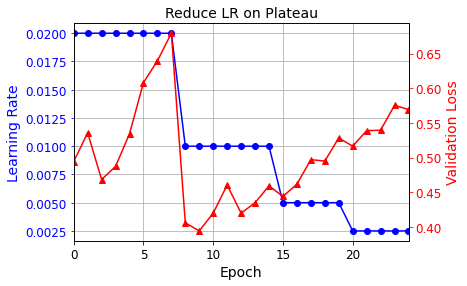

In [95]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [96]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4894 - accuracy: 0.8273 - val_loss: 0.4091 - val_accuracy: 0.8610
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3820 - accuracy: 0.8650 - val_loss: 0.3738 - val_accuracy: 0.8688
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3486 - accuracy: 0.8765 - val_loss: 0.3730 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3264 - accuracy: 0.8835 - val_loss: 0.3494 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3104 - accuracy: 0.8895 - val_loss: 0.3429 - val_accuracy: 0.8796
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2958 - accuracy: 0.8952 - val_loss: 0.3410 - val_accuracy: 0.8824
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2853 - accuracy: 0.8988 - val_loss: 0.3351 - val_accuracy:

Para scheduling constantes:

In [97]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [98]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [99]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.3912


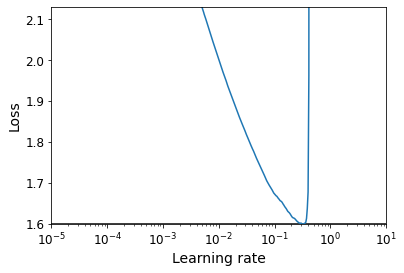

In [100]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [101]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [102]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.7739 - val_loss: 0.4871 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4274 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8586
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3869 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3765 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.8773 - val_loss: 0.3739 - val_accuracy: 0.8708
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3329 - accuracy: 0.8810 - val_loss: 0.3635 - val_accuracy: 0.8710
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [103]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [105]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5838 - accuracy: 0.7998 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4209 - accuracy: 0.8443 - val_loss: 0.3406 - val_accuracy: 0.8726


## Alpha Dropout

In [107]:
tf.random.set_seed(42)
np.random.seed(42)

In [108]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6654 - accuracy: 0.7595 - val_loss: 0.5929 - val_accuracy: 0.8406
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5605 - accuracy: 0.7933 - val_loss: 0.5605 - val_accuracy: 0.8400
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5283 - accuracy: 0.8047 - val_loss: 0.4837 - val_accuracy: 0.8600
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5072 - accuracy: 0.8121 - val_loss: 0.4642 - val_accuracy: 0.8590
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4915 - accuracy: 0.8184 - val_loss: 0.4717 - val_accuracy: 0.8562
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4867 - accuracy: 0.8193 - val_loss: 0.4775 - val_accuracy: 0.8632
Epoch 7/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4725 - accuracy: 0.8245 - val_loss: 0.4750 - val_accuracy:

In [109]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4436 - accuracy: 0.8673


[0.4435863792896271, 0.8672999739646912]

In [110]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3346 - accuracy: 0.8864


[0.3346101641654968, 0.8864181637763977]

In [111]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.4164 - accuracy: 0.8466


## MC Dropout

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [114]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [115]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.23, 0.  , 0.62]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.74, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.29, 0.  , 0.  , 0.  , 0.71]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.16, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.17, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.29, 0.  , 0.71]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.35, 0.  , 0.09, 0.  , 0.56]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.36, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.6 , 0.  , 0.03, 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.06, 0.  , 0.88]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.68, 0.  , 0.05, 0.  , 0.27]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.03, 0.  , 0

In [116]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.08, 0.  , 0.73]],
      dtype=float32)

In [117]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.14, 0.  , 0.26]],
      dtype=float32)

In [118]:
y_pred = np.argmax(y_proba, axis=1)

In [119]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8671

In [120]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [121]:
tf.random.set_seed(42)
np.random.seed(42)

In [122]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [123]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [124]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [125]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [126]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.13, 0.  , 0.68]],
      dtype=float32)

## Max norm

In [127]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [128]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4746 - accuracy: 0.8335 - val_loss: 0.3742 - val_accuracy: 0.8612
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3542 - accuracy: 0.8716 - val_loss: 0.3678 - val_accuracy: 0.8688
